# Exploring Online Order Sales Data

For this challenge, I explore 2 medium sized datasets from an online retailer. The datasets contain transactions and records of the visitors to the site. Let's see what we can find in this data.

## Importing the Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

C:\anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing the Data

In [2]:
os.chdir('..')

In [3]:
DATA_PATH = os.getcwd() + '//data//'
trx_file = 'transactions_202001.csv'
visitor_file = 'visitors_202001.csv'

In [4]:
trx = pd.read_csv(DATA_PATH + trx_file, low_memory=False)
print(trx.shape)
trx.head()

(120662, 7)


,user_id,transaction_id,time,country,items,total,returned_items
0,cadeed9426d287cb9cb651cd7ed4f103,2fa41e338cf91fffba68c6f9fb80add6,1541185315,A,1,18.56,0
1,bb3936cb7bb0f605d187a52ff5e03438,795caad659fc9038034aaf5ecf873e61,1541185411,A,4,34.02,0
2,ae2178e497fc7a38917d950e52ff22ec,29fe89653bb7268b3a7ade23387ba326,1541185455,A,15,346.39,0
3,3421071b1e44d7160cac7dc6accb4f50,a6e04c84c1dd826a6036e26ea513951d,1541185510,C,1,18.56,0
4,82798f7788ad20ce34118c925055c06b,7c849f99090de7ec2322d6d31472a607,1541185706,A,1,58.76,0


In [5]:
visitors = pd.read_csv(DATA_PATH + visitor_file, low_memory=False)
print(visitors.shape)
visitors.head()

(1981904, 9)


,user_id,client,ip_country,gender,year_born,channel,time,minutes,session_id
0,de4c93c3293c76f3aa95c4c57be7e09f,androidapp,A,F,1948,paid,1525762800,4,cfd3f6f2eda4c859d19f5cef56f26351
1,0e399e7047198e3a9fc8c2baed521d60,web,B,M,1985,organic,1525762800,35,54b4133384ab0bfa97675240fa939007
2,2fbb988aa25afb749bfe86bb314a79cb,iosapp,A,F,1999,organic,1525762800,4,b609d8ffaaf5e80075836dcf32580b04
3,763019e3db7510769a85cec170abf53d,androidapp,C,F,1985,organic,1525762800,5,49759218c2c231d4d41592facd2811d0
4,b6835da7d9d3595b6e12c100fca1d51c,iosapp,A,F,1960,organic,1525762800,5,433ae77787d29e5d57778d0c65143ad2


## Exploratory Data Analysis

### Summary judgements

 *  We have 2 datasets - **visitors** and **transactions**. **Visitors** is the larger of the 2 which is a characteristic of online shopping, not every visit translates to a purchase. 
 *  1.98 Million rows in `visitors`, 120662 rows in `trx`, which roughly translates to a purchase every 16 visits. Ideally every online retailer would like to minimize that ratio (while increasing both visitors and transactions). As we explore this data further we'll see if we can find solutions and opportunities to this question of growth.
 *  `country` and `ip_country` in both datasets seem to be anonymized. But there are multiple countries indicating a multi-national operation. This could form an important segmentation feature along with `channel` and `client`.
 *  Categorical Variables - 
     *  country (trx)
     *  ip_country (visitors)
     *  client (visitors)
     *  gender (visitors)
     *  channel (visitors)

### Assumptions

 *  `time` in `trx` is the **checkout** UNIX timestamp.
 *  `time` in `visitors` is the **session start** UNIX timestamp.
 *  Single users can have multiple session IDs. i.e. primary key in `visitors` is `session_id` + `user_id` or `session_id` on it's own.
 *  Similarly primary key in `trx` is `user_id` + `transaction_id` or `transaction_id` on it's own.
 *  Even though `trx` and `visitors` both have `user_id` joining these datasets is harder than it looks. Since `trx` lacks `session_id` to connect a visit to a purchase we will need to creatively use time to come up with a way to join the 2 tables. Something like : `time (visitors)` + `minutes (visitors)` == `time (trx)`

### Sanity checks

In [6]:
trx.dtypes

user_id            object
transaction_id     object
time                int64
country            object
items               int64
total             float64
returned_items      int64
dtype: object

In [7]:
len(trx['user_id'].unique())
## 27k users responsible for 120k trx

27072

In [8]:
len(trx['transaction_id'].unique())
## since this is equal to num of trx => transaction_id is primary key

120662

In [9]:
visitors.dtypes

user_id       object
client        object
ip_country    object
gender        object
year_born      int64
channel       object
time           int64
minutes        int64
session_id    object
dtype: object

In [10]:
len(visitors['user_id'].unique())
## 118k unique visitors, of which 27k have made trx

118577

In [11]:
print(len(visitors['session_id'].unique()))
print(visitors.shape[0])
## this is not equal to num of visitors, we have 18 fewer sessions than visitors. Outliers?

1981896
1981904


### Missing Data

user_id              0
transaction_id       0
time                 0
country           1351
items                0
total                0
returned_items       0
dtype: int64


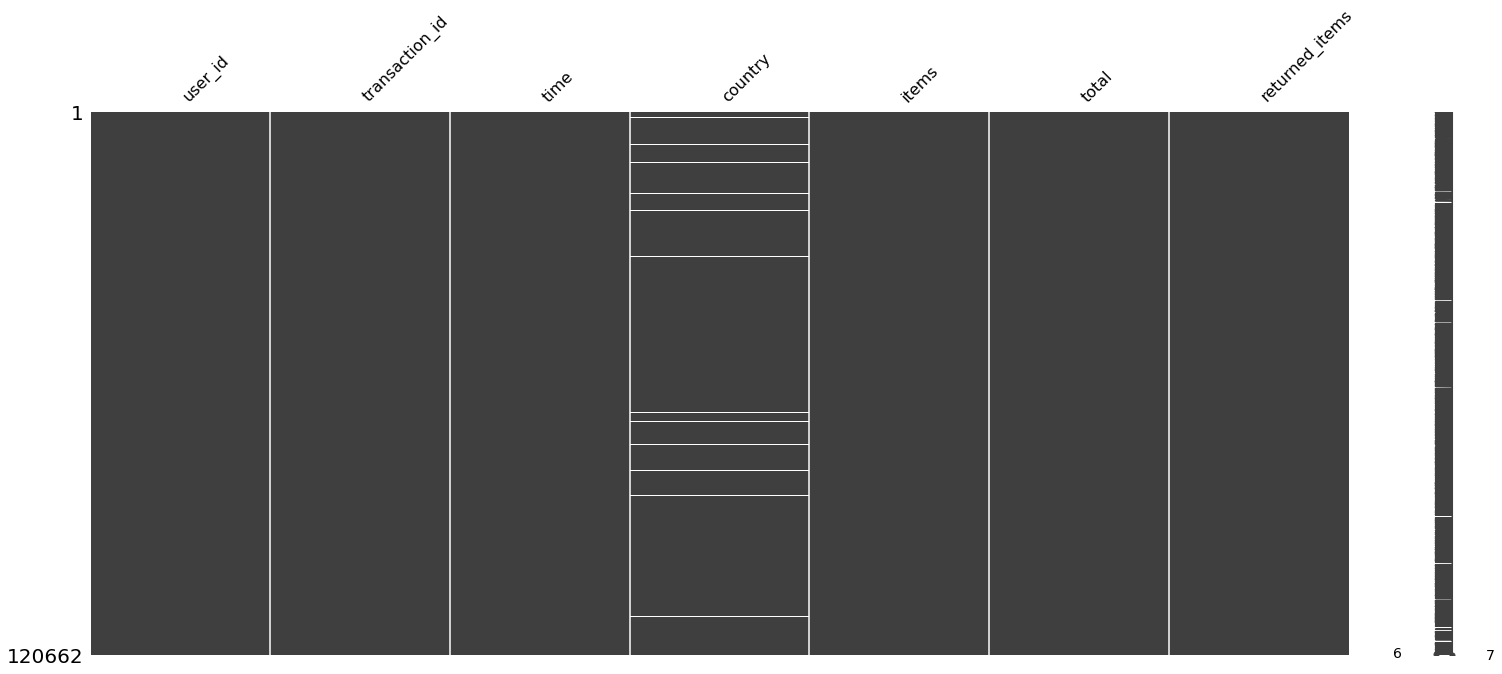

In [12]:
msno.matrix(trx)
print(trx.isnull().sum())

`country` has missing values, we can solve this by - 
1.  imputing the mode (i.e Most common country)
2.  identifying the users and using a location previously recorded for them
3.  using `ip_country` from `visitors` for the corresponding user.

Let's try approach 1

In [13]:
##0a. Check distribution by country
print(trx['country'].value_counts())
##0b. How many missing values?
print(trx[trx.isnull().any(axis=1)].shape[0])
##1. Since, the number of rows missing country is small and country A is the mode by a large margin, 
## we can safely use mode for missing value imputation
trx['country'].fillna(trx['country'].mode()[0], inplace=True)
##2. Check for missing
print(trx[trx.isnull().any(axis=1)].shape[0])

A    80131
B    24339
C    14841
Name: country, dtype: int64
1351
0


In [14]:
# ##1. tie each user to a country:: Group by user, get all countries for that user, get the mode by agg
# user_country = trx.groupby('user_id')['country'].agg(pd.Series.mode)
# ##2. find users with missing country
# missing_country = trx[trx.isnull().any(axis=1)]
# ##3. Join the two
# joined_df =  pd.merge(missing_country, user_country, on='user_id')
# ##4. country_y now has the imputed values, drop country_x and rename country_y to country
# joined_df.drop(['country_x'], inplace=True, axis=1)
# joined_df.rename({'country_y':'country'}, axis=1, inplace=True)
# ##5. Join back to trx
# trx = joined_df[['user_id', 'transaction_id', 'country']]

user_id       0
client        0
ip_country    0
gender        0
year_born     0
channel       0
time          0
minutes       0
session_id    0
dtype: int64


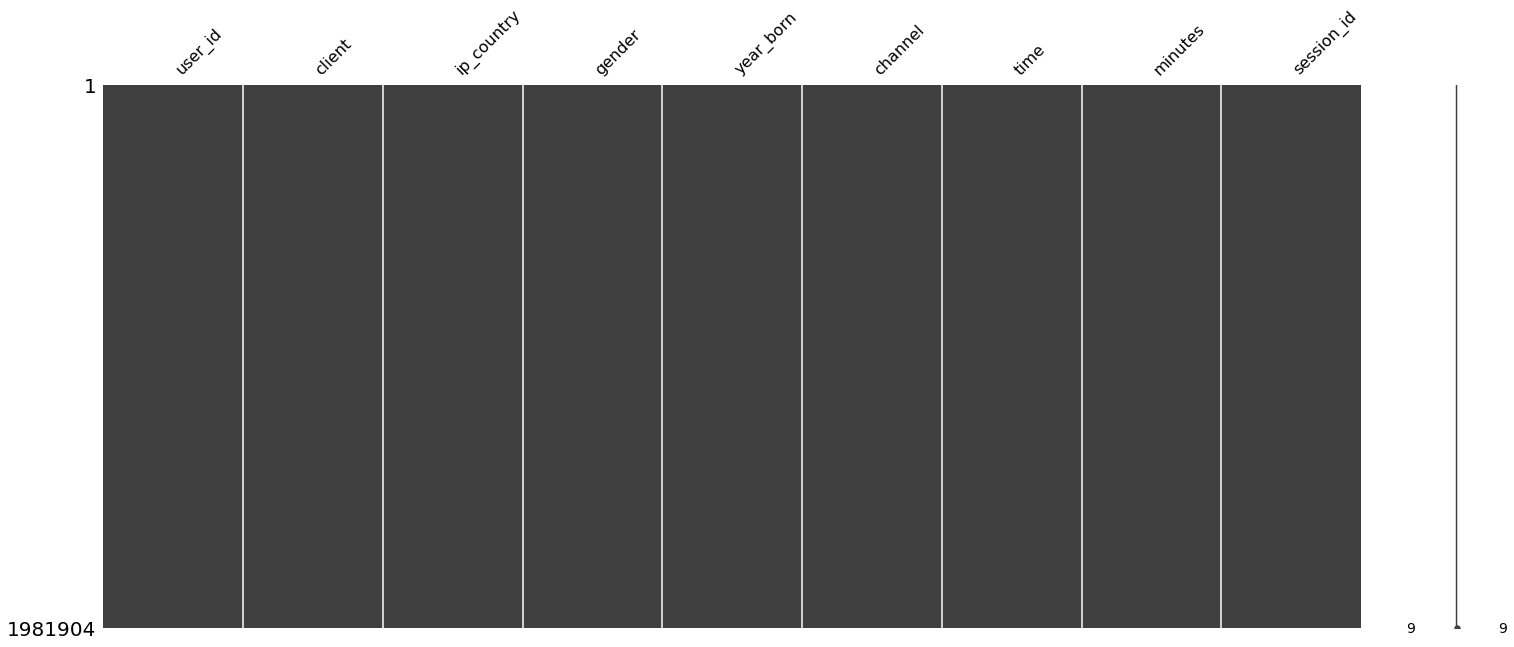

In [15]:
msno.matrix(visitors)
print(visitors.isnull().sum())